Suppose we have a controller. We can summarize it's properties for a 1D controller by plotting a graph of it's values. We'll do this to analyze our controllers.

In [1]:
## Our imports

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from collections import deque
import time
import random

from gymnasium import spaces
import molcontrol

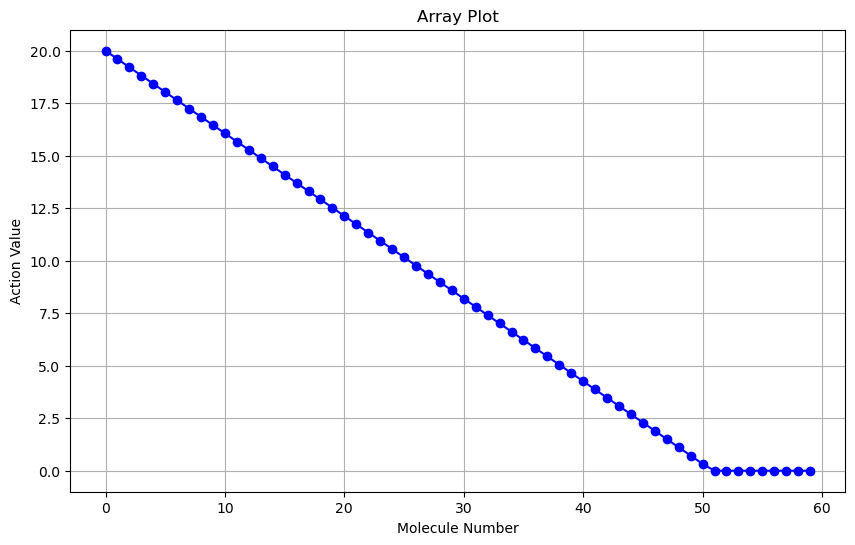

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def optimal_action_th(molecules, target, molecule_lifetime, dt):
    prob_death = np.exp(-dt/molecule_lifetime)
    optimal_action = target - molecules*(1 - prob_death)
    return optimal_action

def control_plot_1d(model, upper_mol, molecule_lifetime, dt):
    action_vals = np.zeros(upper_mol)
    for cyc in range(upper_mol):
        mol = torch.tensor([cyc], dtype=torch.float32)
        action_vals[cyc] = model(mol)
    return action_vals

def control_plot_1dopt(upper_mol, target, molecule_lifetime, dt):
    action_vals = np.zeros(upper_mol)
    for cyc in range(upper_mol):
        action_vals[cyc] = max(optimal_action_th(cyc, target, molecule_lifetime, dt), 0)
    return action_vals

def plot_array(data, title="Array Plot", xlabel="Index", ylabel="Value"):
    plt.figure(figsize=(10, 6))
    plt.plot(data, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

steps = 10000
target = 20
molecule_lifetime = 1.0
dt = 0.5
upper_mol = target*3
action_vals_th = control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plot_array(action_vals_th, xlabel="Molecule Number", ylabel="Action Value")

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from collections import deque
import time
import random

from gymnasium import spaces

class ReplayMemory: ##Replay memory to store past experiences to learn from
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def add(self, experience):
        self.memory.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class NeuralNetwork(nn.Module): ##Our controller is a neural network that takes in input dimension (the history length) and outputs a single number
    ##Because output has numerical meaning (5 is in fact close to 4 and 6 as outputs) we'll output a single integer instead of a number of categories
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential( ##2 layers of 64 neurons. Maybe we need more complexity later.
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


def step_function(model, optimizer, loss_fn, states, outs):
    model.train()
    
    predict_output = model(states)
    loss = loss_fn(predict_output, outs)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

##Our memory contains states and the optimal output value
def train_from_memory(model, optimizer, loss_fn, replay_memory, batch_size):
    if len(replay_memory) < batch_size:
        return 0

    batch = replay_memory.sample(batch_size)
    state_list, output_list = zip(*batch)

    #print (state_list)
    #print ("The state list is ", state_list)
    #print ("The output list is ", output_list)

    states = torch.tensor(np.array(state_list), dtype=torch.float32)
    #print ("The state tensor is ", states)
    outputs = torch.tensor(np.array(output_list), dtype=torch.float32).unsqueeze(1)
    #print ("The output tensor is ", outputs)

    loss = step_function(model, optimizer, loss_fn, states, outputs)
    return loss

class OneMoleculeEnv(gym.Env):
    def __init__(self, initial_value=10, molecule_lifetime = 1, dt = 0.1, max_steps=100, history_length=5, target_value=10, obs_cap=100, render_mode=None):
        super(OneMoleculeEnv, self).__init__()

        self.initial_value = initial_value
        self.prob_death = np.exp(-dt/molecule_lifetime)
        self.dt = dt
        self.max_steps = max_steps
        self.history_length = history_length
        self.target_value = target_value
        self.obs_cap = obs_cap  # Cap for the observation space
        self.render_mode = render_mode

        self.current_value = initial_value
        self.current_step = 0
        self.decays = 0
        self.ideal_action = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(obs_cap)  # the number of molecules to send in ranges from 0 to the cap
        self.observation_space = spaces.Box(
            low=0, high=obs_cap, shape=(history_length,), dtype=np.float32
        )

        # Initialize the history of values
        self.history = np.full(history_length, initial_value, dtype=np.float32)

        # Pre-generate random numbers to avoid generating them at each step
        self.random_numbers = np.random.rand(max_steps)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            self.random_numbers = np.random.rand(self.max_steps)  # Re-generate random numbers if seeded
        self.current_value = self.initial_value
        self.current_step = 0
        self.history = np.full(self.history_length, self.initial_value, dtype=np.float32)
        return self.history, {}

    def _ensure_random_numbers(self):
        # Reset the random numbers if current_step exceeds max_steps
        if self.current_step >= self.max_steps:
            self.random_numbers = np.random.rand(self.max_steps)
            self.current_step = 0  # Reset current step to start fresh

    # First, ensure enough random numbers are available
    # The probability a molecule has decayed in the time interval given is dependent on dt and the lifetime.
    # Decrease the value with a number drawn from a binomial distribution
    # This reflects each molecule having a finite probability of decaying in the timestep
    # The probability a molecule has decayed in the time interval given is dependent on dt and the lifetime.
    # Then add molecules.
    # We then update the history, increase the steps, and calculate the error (reward)
    # Then return the standard gymnasium properties.
    def step(self, action):
        # Ensure enough random numbers are available
        self._ensure_random_numbers()

        self.decays = -np.random.binomial((int)(self.current_value), self.prob_death, 1).item()
        self.current_value += self.decays
        self.ideal_action = self.target_value - self.current_value
        self.current_value += action
        #print ("The options for self current value are ")
        #print (self.current_value, ' ', self.obs_cap)
        #print (self.obs_cap, ' vs ', self.current_value)

        self.current_value = min(self.current_value, self.obs_cap)

        self.history[:-1] = self.history[1:]
        self.history[-1] = np.float32(self.current_value)  # Ensure it's a scalar

        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        reward = -float((self.current_value - self.target_value) ** 2)  # Ensure the reward is a float

        return self.history, reward, done, done, self.ideal_action

    def render(self):
        if self.render_mode == 'human':
            print(f"Step: {self.current_step}, Value: {self.current_value}, History: {self.history}")

    def close(self):
        pass

def train_molecule_controller(model, optimizer, loss_fn, replay_memory, steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size):
    ##Here we choose our environment
    env = OneMoleculeEnv(
        initial_value=target,
        molecule_lifetime=molecule_lifetime,
        dt=dt,
        max_steps=steps,
        history_length=history_length,
        target_value=target,
        obs_cap=target*3,
        render_mode=None
    )
    
    RUN_SEED = 0
    
    observation, info = env.reset(seed=RUN_SEED)
    observation_tensor = torch.tensor(observation[observable_indices], dtype=torch.float32).unsqueeze(0)

    print (observation[observable_indices])
    print (observation_tensor)
    
    for step in range(steps):

        ##we compute our optimal action using the most 
        #print (observation[observable_indices])
        with torch.no_grad():
            action = model(observation_tensor)
        action[action <0] = 0 ##controller cannot remove molecules
        rounded_action = torch.round(action).int().item() ##round the action to the nearest integer
        observation, reward, done, truncated, info = env.step(rounded_action)
        observation_tensor = torch.tensor(observation[observable_indices], dtype=torch.float32).unsqueeze(0)
        #print ("Action taken ", rounded_action, ' ideal action ', info, ' current observation ', observation_tensor)
        replay_memory.add((observation_tensor, info))

        q_error = train_from_memory(model, optimizer, loss_fn, replay_memory, batch_size)
    env.close()
    return 0

def test_molecule_controller(model, optimizer, loss_fn, replay_memory, steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size):
    ##Here we choose our environment
    env = OneMoleculeEnv(
        initial_value=target,
        molecule_lifetime=molecule_lifetime,
        dt=dt,
        max_steps=steps,
        history_length=history_length,
        target_value=target,
        obs_cap=target*3,
        render_mode=None
    )
    
    rewards = []
    training_error = []
    RUN_SEED = 0
    
    observation, info = env.reset(seed=RUN_SEED)
    observation_tensor = torch.tensor(observation[observable_indices], dtype=torch.float32).unsqueeze(0)
    
    for step in range(steps):

        ##we compute our optimal action using the most 
        #print (observation[observable_indices])
        with torch.no_grad():
            action = model(observation_tensor)
        action[action <0] = 0 ##controller cannot remove molecules
        rounded_action = torch.round(action).int().item() ##round the action to the nearest integer
        observation, reward, done, truncated, info = env.step(rounded_action)
        observation_tensor = torch.tensor(observation[observable_indices], dtype=torch.float32).unsqueeze(0)
        #print ("Action taken ", rounded_action, ' ideal action ', info, ' current observation ', observation_tensor)
        replay_memory.add((observation_tensor, info))

        q_error = train_from_memory(model, optimizer, loss_fn, replay_memory, batch_size)
        if q_error > 0:
            training_error.append(q_error)
        rewards.append(reward)
    env.close()
    return np.array(rewards), np.array(training_error)

def plot_with_smoothing(data, xlabel, ylabel, title, smoothing_window=1):
    #- smoothing_window: int, the number of observations to average out for smoothing. If set to 1, no smoothing is applied.
    # Apply smoothing if smoothing_window is greater than 1
    if smoothing_window > 1:
        smoothed_data = np.convolve(data, np.ones(smoothing_window)/smoothing_window, mode='valid')
        # Plot the smoothed data with original indices adjusted for the window
        plt.plot(range(smoothing_window-1, len(data)), smoothed_data, label=f'Smoothed (window={smoothing_window})')
    else:
        # If no smoothing is required, just plot the original data
        plt.plot(data, label='Original Data')

    # Plot the original data for comparison
    plt.plot(data, alpha=0.3, label='Original Data (Transparent)')
    
    # Add labels and a legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend()
    
    # Show the plot
    plt.show()

def optimal_action_th(molecules, target, molecule_lifetime, dt):
    prob_death = np.exp(-dt/molecule_lifetime)
    optimal_action = target - molecules*(1 - prob_death)
    return optimal_action

def optimal_solution(steps, target, molecule_lifetime, dt = 0.5, RUN_SEED = 0):
    ##Here we choose our environment
    env = OneMoleculeEnv(
        initial_value=target,
        molecule_lifetime=molecule_lifetime,
        dt=dt,
        max_steps=steps,
        history_length=1,
        target_value=target,
        obs_cap=target*3,
        render_mode=None
    )
        
    rewards = []
    observation, info = env.reset(seed=RUN_SEED)
    
    for step in range(steps):

        ##we compute our optimal action using the most 
        action = optimal_action_th(observation[-1], target, molecule_lifetime, dt)
        rounded_action = (int)(np.round(action))
        observation, reward, done, truncated, info = env.step(rounded_action)
        #print ("Reward ", reward, " Observation ", observation, " Action ", action)

        ##The error is the negative of the reward
        rewards.append(reward)
    env.close()
    return np.array(rewards)

def end_average(arr, number):
    return np.mean(arr[-number:])

In [2]:
steps = 10
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 200

train_steps = 10
model = NeuralNetwork(input_dim = 1)
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = ReplayMemory(capacity=2000)

upper_mol = target*3

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)


plt.figure(figsize=(10, 6))
plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')

plt.legend(loc = 'best')

plt.title("Action Values")
plt.xlabel("Molecule Number")
plt.ylabel("Action")
plt.grid(True)
plt.show()



20.0
tensor([20.])


NameError: name 'control_plot_1d' is not defined

We find that bizzarely, our algorithm is actually getting worse and worse over time! There is something wrong with the way we're training this controller. It suggests that our learning rate may be too high.

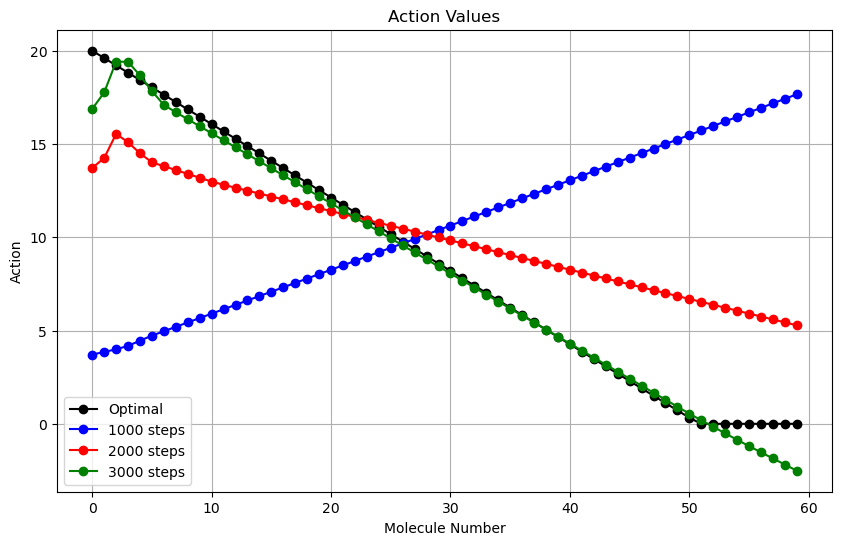

In [23]:
steps = 1000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 200

train_steps = 1000
model = NeuralNetwork(input_dim = 1)
learning_rate = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = ReplayMemory(capacity=2000)

upper_mol = target*3

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)


plt.figure(figsize=(10, 6))
plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')

plt.legend(loc = 'best')

plt.title("Action Values")
plt.xlabel("Molecule Number")
plt.ylabel("Action")
plt.grid(True)
plt.show()


In [24]:

train_steps = 2000

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

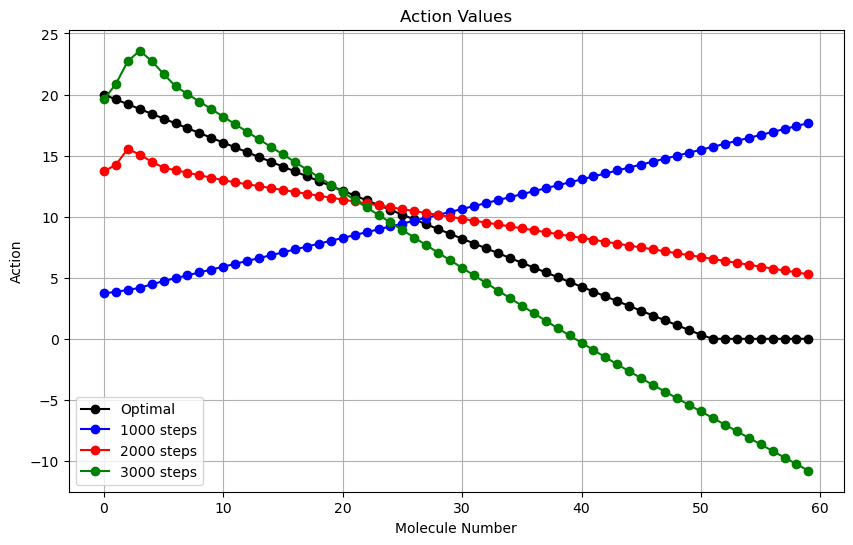

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')

plt.legend(loc = 'best')

plt.title("Action Values")
plt.xlabel("Molecule Number")
plt.ylabel("Action")
plt.grid(True)
plt.show()

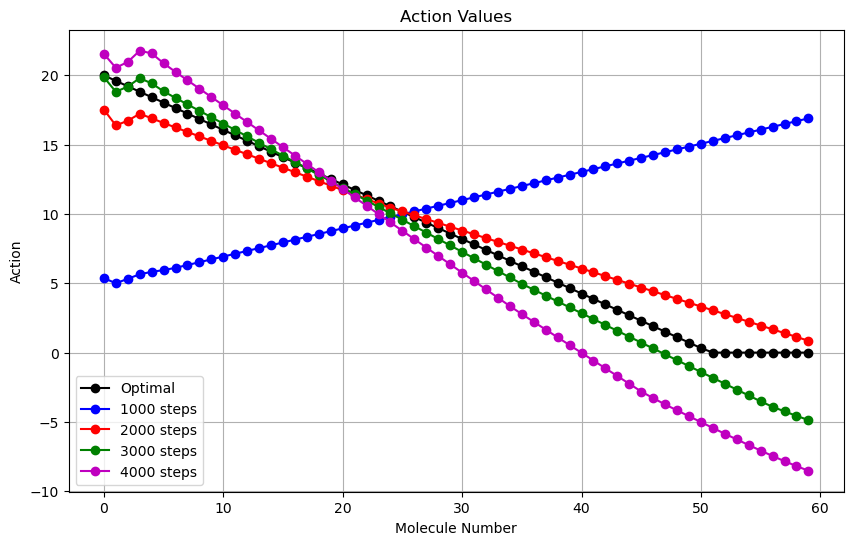

In [28]:
steps = 1000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 200

train_steps = 1000
model = NeuralNetwork(input_dim = 1)
learning_rate = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = ReplayMemory(capacity=2000)

upper_mol = target*3

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val4 = control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)


plt.figure(figsize=(10, 6))
plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')
plt.plot(action_val4, marker='o', linestyle='-', color='m', label = '4000 steps')

plt.legend(loc = 'best')

plt.title("Action Values")
plt.xlabel("Molecule Number")
plt.ylabel("Action")
plt.grid(True)
plt.show()

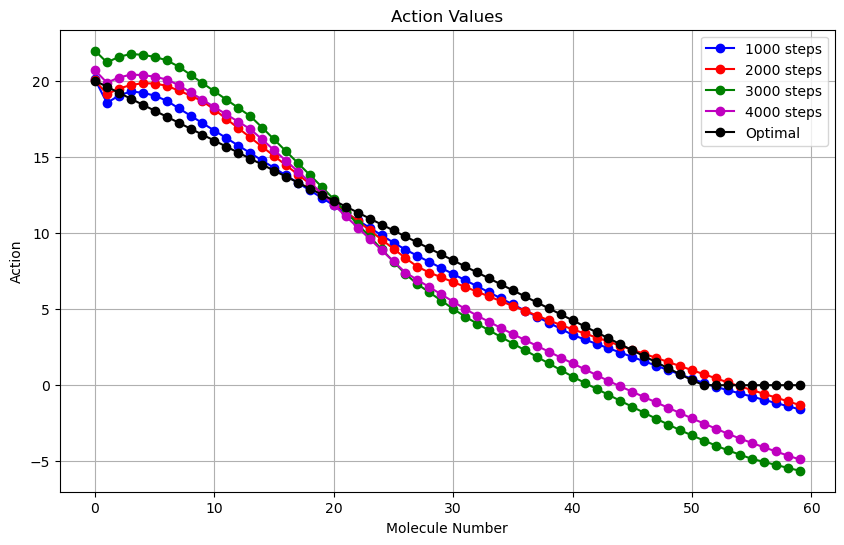

In [5]:
steps = 10000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 200

train_steps = 1000
model = molcontrol.NeuralNetwork(input_dim = 1)
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = molcontrol.ReplayMemory(capacity=2000)

upper_mol = target*3

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val4 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = molcontrol.control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plt.figure(figsize=(10, 6))
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')
plt.plot(action_val4, marker='o', linestyle='-', color='m', label = '4000 steps')

plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.legend(loc = 'best')
plt.title("Action Values")
plt.xlabel("Molecule Number")
plt.ylabel("Action")
plt.grid(True)
plt.show()

In [1]:
steps = 10000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 200

train_steps = 1000
model = molcontrol.NeuralNetwork(input_dim = 1)
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = molcontrol.ReplayMemory(capacity=4000)

upper_mol = target*3

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val4 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = molcontrol.control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plt.figure(figsize=(10, 6))
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')
plt.plot(action_val4, marker='o', linestyle='-', color='m', label = '4000 steps')

plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.legend(loc = 'best')
#plt.title("Action Values")
plt.xlabel("Number of Current Molecules", fontsize = 20)
plt.ylabel("Action (Number of Input Molecules)", fontsize = 20)
plt.grid(True)
plt.savefig()
plt.show()

NameError: name 'molcontrol' is not defined

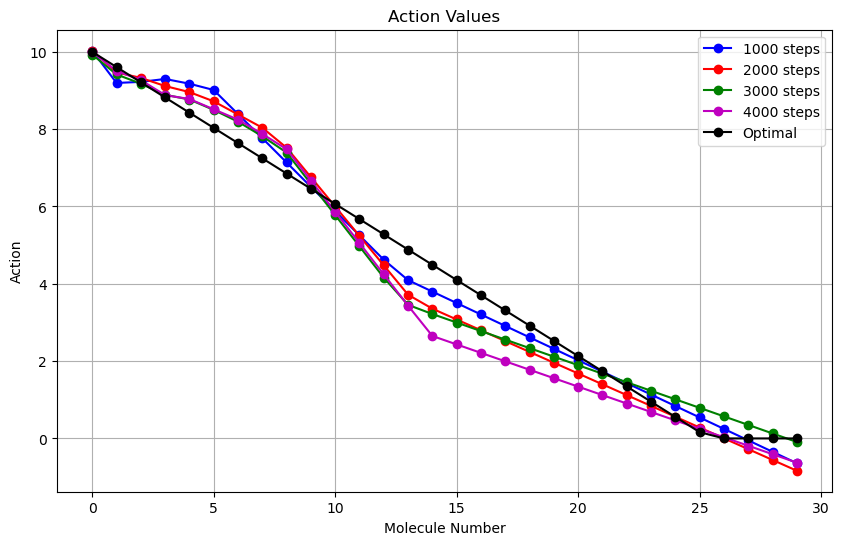

In [3]:
steps = 10000
target = 10
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 200

train_steps = 1000
model = molcontrol.NeuralNetwork(input_dim = 1)
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = molcontrol.ReplayMemory(capacity=4000)

upper_mol = target*3

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val4 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = molcontrol.control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plt.figure(figsize=(10, 6))
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')
plt.plot(action_val4, marker='o', linestyle='-', color='m', label = '4000 steps')

plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.legend(loc = 'best')
plt.title("Action Values")
plt.xlabel("Molecule Number")
plt.ylabel("Action")
plt.grid(True)
plt.show()

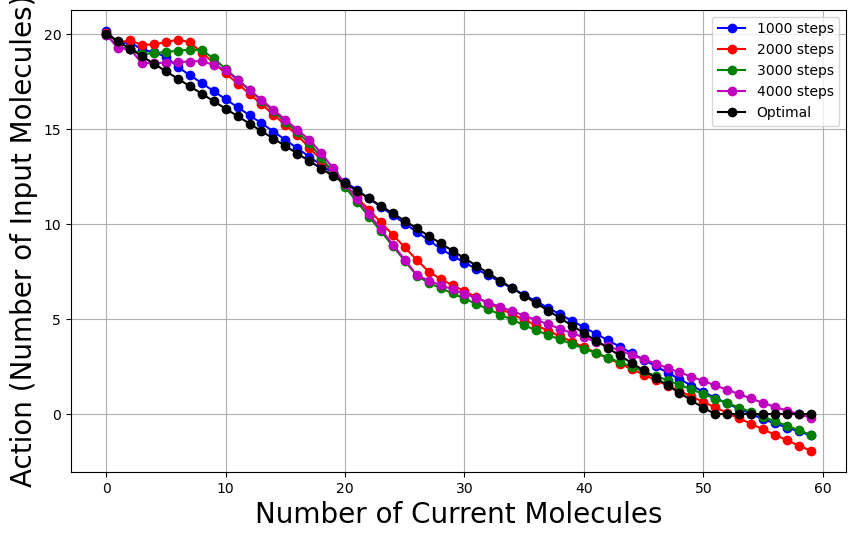

In [4]:
steps = 10000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 200

train_steps = 1000
model = molcontrol.NeuralNetwork(input_dim = 1)
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = molcontrol.ReplayMemory(capacity=4000)

upper_mol = target*3

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val4 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = molcontrol.control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plt.figure(figsize=(10, 6))
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')
plt.plot(action_val4, marker='o', linestyle='-', color='m', label = '4000 steps')

plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.legend(loc = 'best')
#plt.title("Action Values")
plt.xlabel("Number of Current Molecules", fontsize = 20)
plt.ylabel("Action (Number of Input Molecules)", fontsize = 20)
plt.grid(True)
plt.savefig("Training_gets_worse.png")
plt.show()

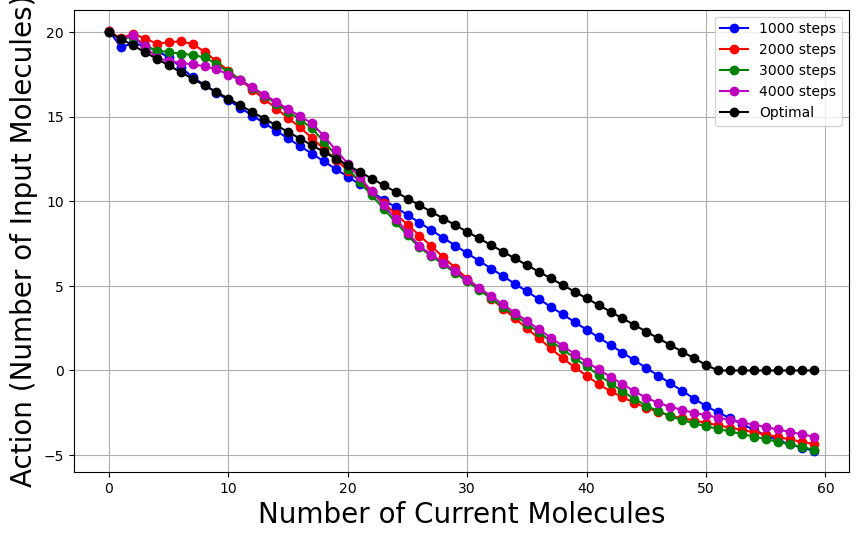

In [6]:
steps = 10000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 400

train_steps = 1000
model = molcontrol.NeuralNetwork(input_dim = 1)
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = molcontrol.ReplayMemory(capacity=4000)

upper_mol = target*3

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val4 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = molcontrol.control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plt.figure(figsize=(10, 6))
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')
plt.plot(action_val4, marker='o', linestyle='-', color='m', label = '4000 steps')

plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.legend(loc = 'best')
#plt.title("Action Values")
plt.xlabel("Number of Current Molecules", fontsize = 20)
plt.ylabel("Action (Number of Input Molecules)", fontsize = 20)
plt.grid(True)
plt.savefig("Training_gets_worse2.png")
plt.show()

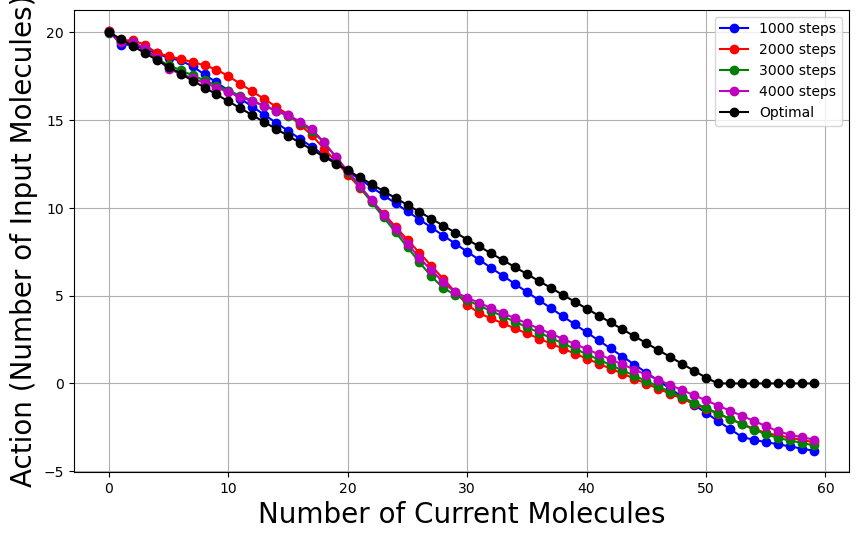

In [4]:
steps = 10000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = 0

RUN_SEED = 0
batch_size = 400

train_steps = 1000
model = molcontrol.NeuralNetwork((1, 64, 64, 1))
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
replay_memory = molcontrol.ReplayMemory(capacity=4000)

upper_mol = target*3

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val1 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val2 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val3 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, train_steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
action_val4 = molcontrol.control_plot_1d(model, upper_mol, molecule_lifetime, dt)

action_vals_th = molcontrol.control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plt.figure(figsize=(10, 6))
plt.plot(action_val1, marker='o', linestyle='-', color='b', label = '1000 steps')
plt.plot(action_val2, marker='o', linestyle='-', color='r', label = '2000 steps')
plt.plot(action_val3, marker='o', linestyle='-', color='g', label = '3000 steps')
plt.plot(action_val4, marker='o', linestyle='-', color='m', label = '4000 steps')

plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.legend(loc = 'best')
#plt.title("Action Values")
plt.xlabel("Number of Current Molecules", fontsize = 20)
plt.ylabel("Action (Number of Input Molecules)", fontsize = 20)
plt.grid(True)
plt.savefig("Training_gets_worse3.png")
plt.show()